In [4]:
import numpy as np
from time_integrators import RK2, RK4, theta_scheme
from scipy.optimize import root
import pylab as pl
%matplotlib inline

pl.style.use('latexplot')

In [5]:
# Defining the x-domain:
x_start = 0
x_end   = 40
N_x     = 401
dx      = (x_end - x_start) / N_x

# Number of ghost cells:
N_g     = 1
x       = x_start + (0.5 + np.arange(-N_g, N_x + N_g)) * dx

In [6]:
# Defining the time array:
t_final = 20
N_t     = 20001
t       = np.linspace(0, t_final, N_t)
dt      = t[1] - t[0]

In [53]:
# Defining the dimensionless concentration of species A:
a0 = x**0

# The applied potential is going to be varied as E(t) = E_start + t
# Below, we are defining E_start (starting potential) (dicated by experimenter):
E_start = -10
# Formal potential (dictated by chemical)
E0 = -1
# Rate constant of the reaction:
k0 = 35
# Charge transfer coefficient:
alpha = 0.5

# Time period for cyclic voltametry:
t_rev = 20

# Parameters for AC
delta_E = 0.1
omega   = 4 * np.pi

In [8]:
# Applied potential for linear voltametry:
def E_linear(t):
    return(E_start + t)
# Applied potential for cyclic voltametry:
def E_cyclic(t):
    if((t % (2 * t_rev)) <= t_rev):
        return(E_start + t)
    else:
        return(E_start + 2 * t_rev - (t % (2 * t_rev)))
def E_sine(t, delta_E, omega):
    return(E_linear(t) + delta_E * np.sin(omega * t))

In [9]:
# Forcing function:
def F(a, t, delta_E, omega):
    return(k0 * (a * np.exp((1 - alpha) * (E_sine(t, delta_E, omega) - E0)) - (1-a) * np.exp(-alpha * (E_sine(t, delta_E, omega) - E0))))

In [10]:
def apply_bcs(a, t, delta_E, omega):
    # Applying the boundary conditions:
    a[0] = root(lambda x: a[1] - x - F(0.5 * (a[1] + x), t, delta_E, omega) * dx, a[1]).x
    # Boundary condition at x = infty
    a[-N_g:] = 1
    return(a)

In [11]:
def da_dt(a, t, delta_E, omega):
    # Applying the boundary conditions:
    a = apply_bcs(a, t, delta_E, omega)
    # Evaluating the 2nd derivative using central differences:
    d2a_dx2 = (np.roll(a, -1) + np.roll(a, 1) - 2 * a) / dx**2
    return d2a_dx2

In [15]:
# Evaluating the DC current:
Idc = np.zeros(t.size)
# Initial value of a:
a = a0
for i in range(t.size - 1):
    a = RK4(da_dt, a, t[i], t[i + 1], 0, 0)
    a = apply_bcs(a, t[i+1], 0, 0)
    Idc[i] = (a[1] - a[0]) / dx

In [16]:
def get_peak_ac_current(delta_E, omega):
    # Evaluating the current:
    I = np.zeros(t.size)
    # Initial value of a:
    a = a0
    for i in range(t.size - 1):
        a = RK4(da_dt, a, t[i], t[i + 1], delta_E, omega)
        a = apply_bcs(a, t[i+1], delta_E, omega)
        I[i] = (a[1] - a[0]) / dx
    return (I-Idc).max()

In [19]:
deltaE_array = np.arange(0.1, 1.1, 0.2)
peaks1 = np.zeros(deltaE_array.size)
for i in range(deltaE_array.size):
    peaks1[i] = get_peak_ac_current(deltaE_array[i], 2 * np.pi)

In [24]:
deltaE_array = np.arange(0.1, 1.1, 0.2)
peaks2 = np.zeros(deltaE_array.size)
for i in range(deltaE_array.size):
    peaks2[i] = get_peak_ac_current(deltaE_array[i], 4 * np.pi)

In [25]:
deltaE_array = np.arange(0.1, 1.1, 0.2)
peaks3 = np.zeros(deltaE_array.size)
for i in range(deltaE_array.size):
    peaks3[i] = get_peak_ac_current(deltaE_array[i], 8 * np.pi)

In [26]:
deltaE_array = np.arange(0.1, 1.1, 0.2)
peaks4 = np.zeros(deltaE_array.size)
for i in range(deltaE_array.size):
    peaks4[i] = get_peak_ac_current(deltaE_array[i], 16 * np.pi)

In [37]:
from scipy.interpolate import interp1d
f1 = interp1d(deltaE_array[0:2], peaks1[0:2], fill_value = 'extrapolate')
f2 = interp1d(deltaE_array[0:2], peaks2[0:2], fill_value = 'extrapolate')
f3 = interp1d(deltaE_array[0:2], peaks3[0:2], fill_value = 'extrapolate')
f4 = interp1d(deltaE_array[0:2], peaks4[0:2], fill_value = 'extrapolate')

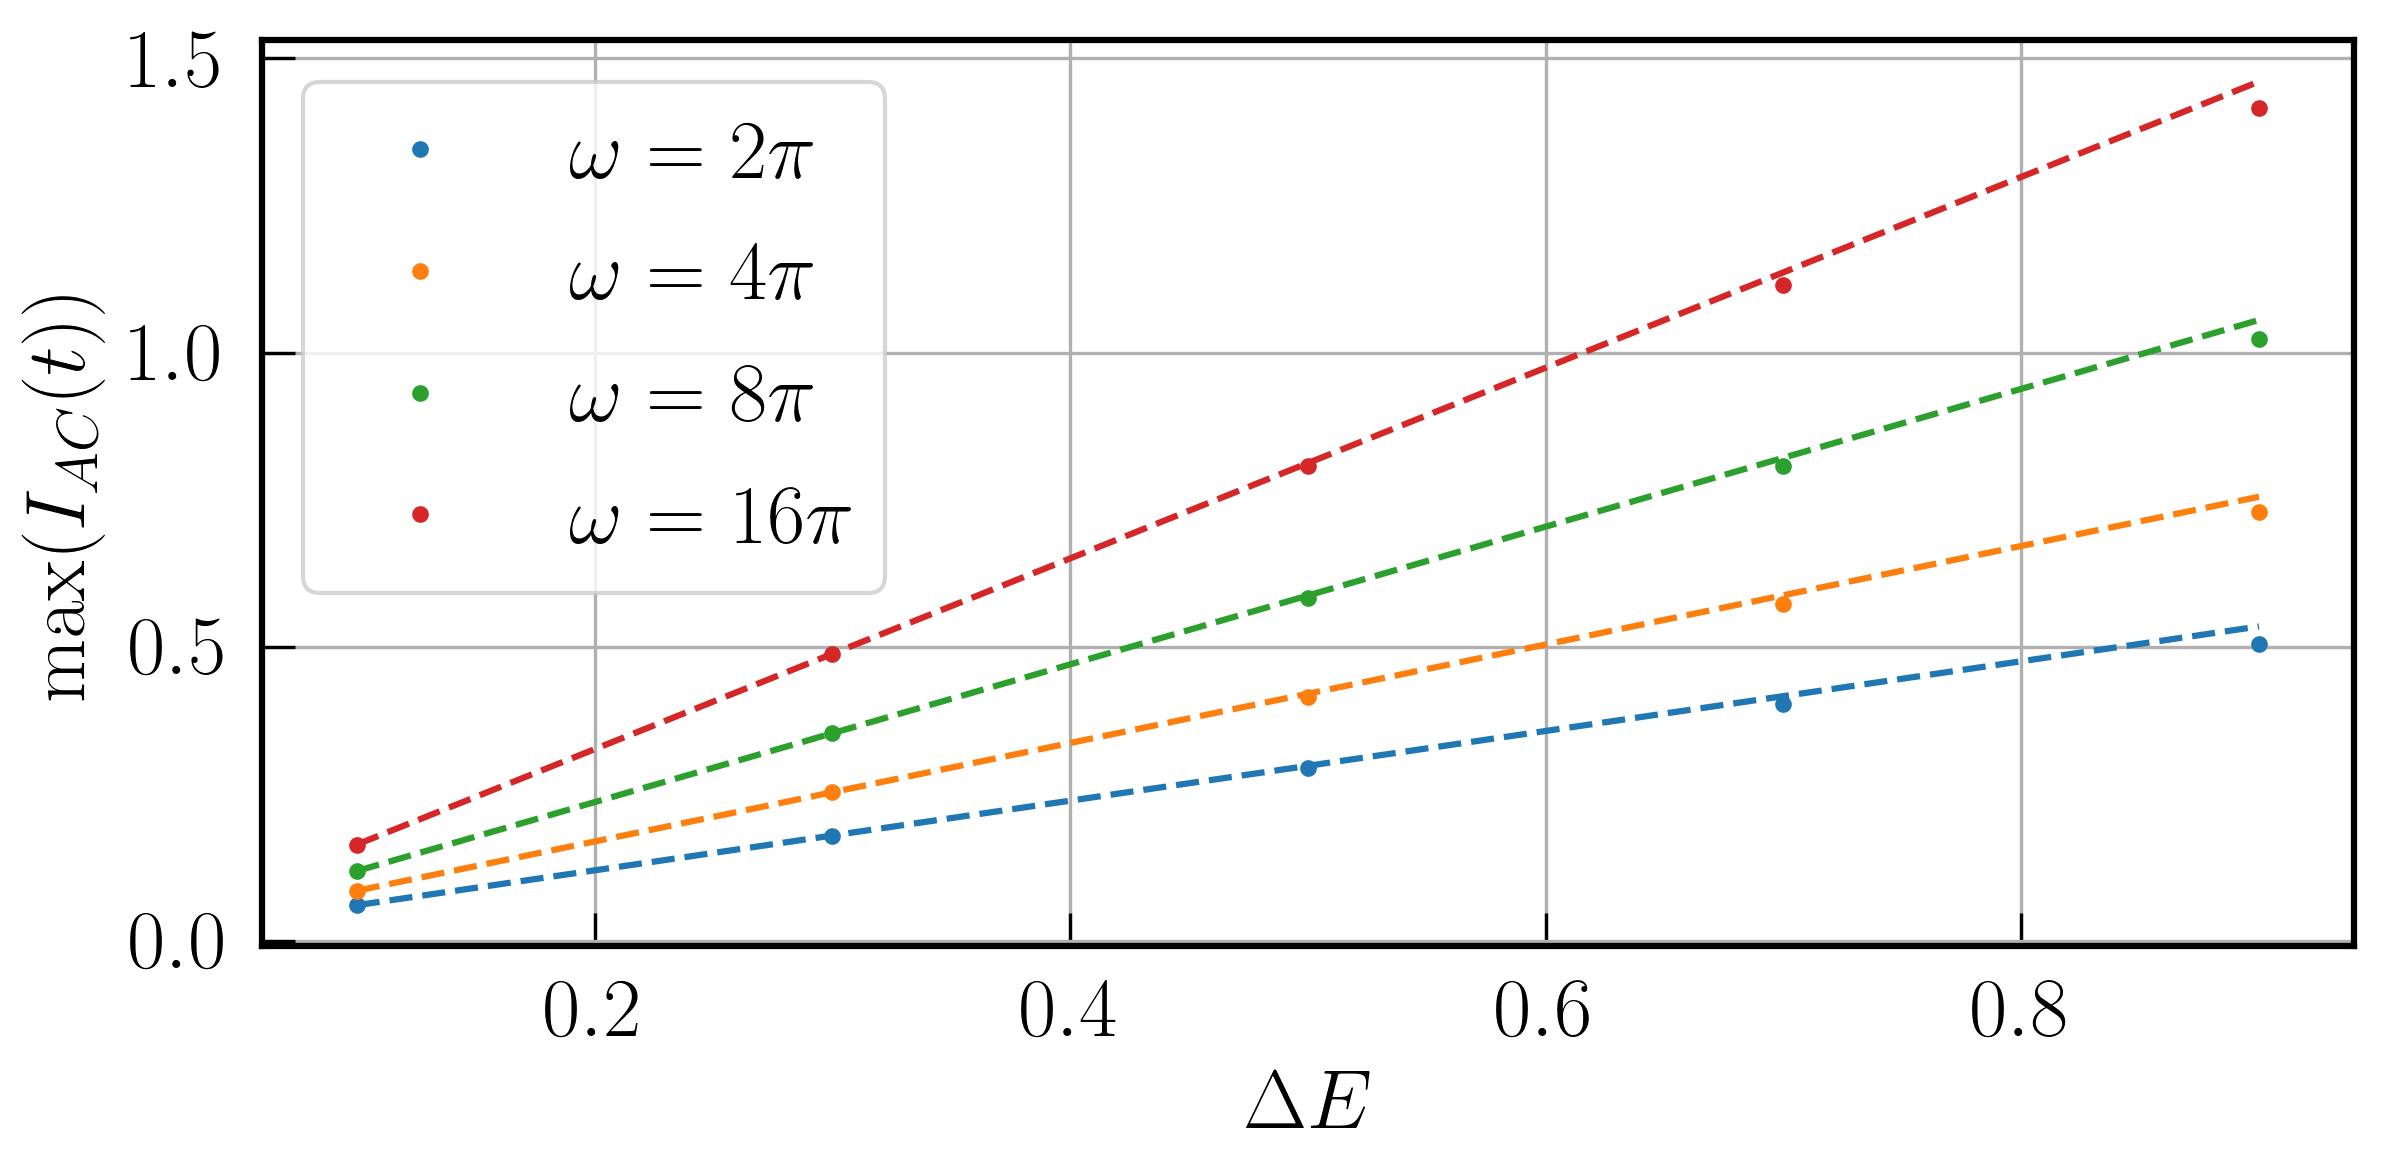

In [44]:
pl.plot(deltaE_array, peaks1, 'C0.', label = r'$\omega = 2\pi$')
pl.plot(deltaE_array, f1(deltaE_array), 'C0--')

pl.plot(deltaE_array, peaks2, 'C1.', label = r'$\omega = 4\pi$')
pl.plot(deltaE_array, f2(deltaE_array), 'C1--')

pl.plot(deltaE_array, peaks3, 'C2.', label = r'$\omega = 8\pi$')
pl.plot(deltaE_array, f3(deltaE_array), 'C2--')

pl.plot(deltaE_array, peaks4, 'C3.', label = r'$\omega = 16\pi$')
pl.plot(deltaE_array, f4(deltaE_array), 'C3--')

pl.xlabel(r'$\Delta E$')
pl.ylabel(r'$\max(I_{AC}(t))$')
pl.grid()
pl.legend()
pl.savefig('peak_currents1.png', bbox_inches = 'tight')

In [46]:
deltaomega_array = np.arange(1, 6)**2 * np.pi
peaks1 = np.zeros(deltaomega_array.size)
for i in range(deltaomega_array.size):
    peaks1[i] = get_peak_ac_current(0.2, deltaomega_array[i])

In [47]:
deltaomega_array = np.arange(1, 6)**2 * np.pi
peaks2 = np.zeros(deltaomega_array.size)
for i in range(deltaomega_array.size):
    peaks2[i] = get_peak_ac_current(0.4, deltaomega_array[i])

In [48]:
deltaomega_array = np.arange(1, 6)**2 * np.pi
peaks3 = np.zeros(deltaomega_array.size)
for i in range(deltaomega_array.size):
    peaks3[i] = get_peak_ac_current(0.6, deltaomega_array[i])

In [49]:
deltaomega_array = np.arange(1, 6)**2 * np.pi
peaks4 = np.zeros(deltaomega_array.size)
for i in range(deltaomega_array.size):
    peaks4[i] = get_peak_ac_current(0.8, deltaomega_array[i])

In [50]:
f1 = interp1d(np.sqrt(deltaomega_array[0:2] / np.pi), peaks1[0:2], fill_value = 'extrapolate')
f2 = interp1d(np.sqrt(deltaomega_array[0:2] / np.pi), peaks2[0:2], fill_value = 'extrapolate')
f3 = interp1d(np.sqrt(deltaomega_array[0:2] / np.pi), peaks3[0:2], fill_value = 'extrapolate')
f4 = interp1d(np.sqrt(deltaomega_array[0:2] / np.pi), peaks4[0:2], fill_value = 'extrapolate')

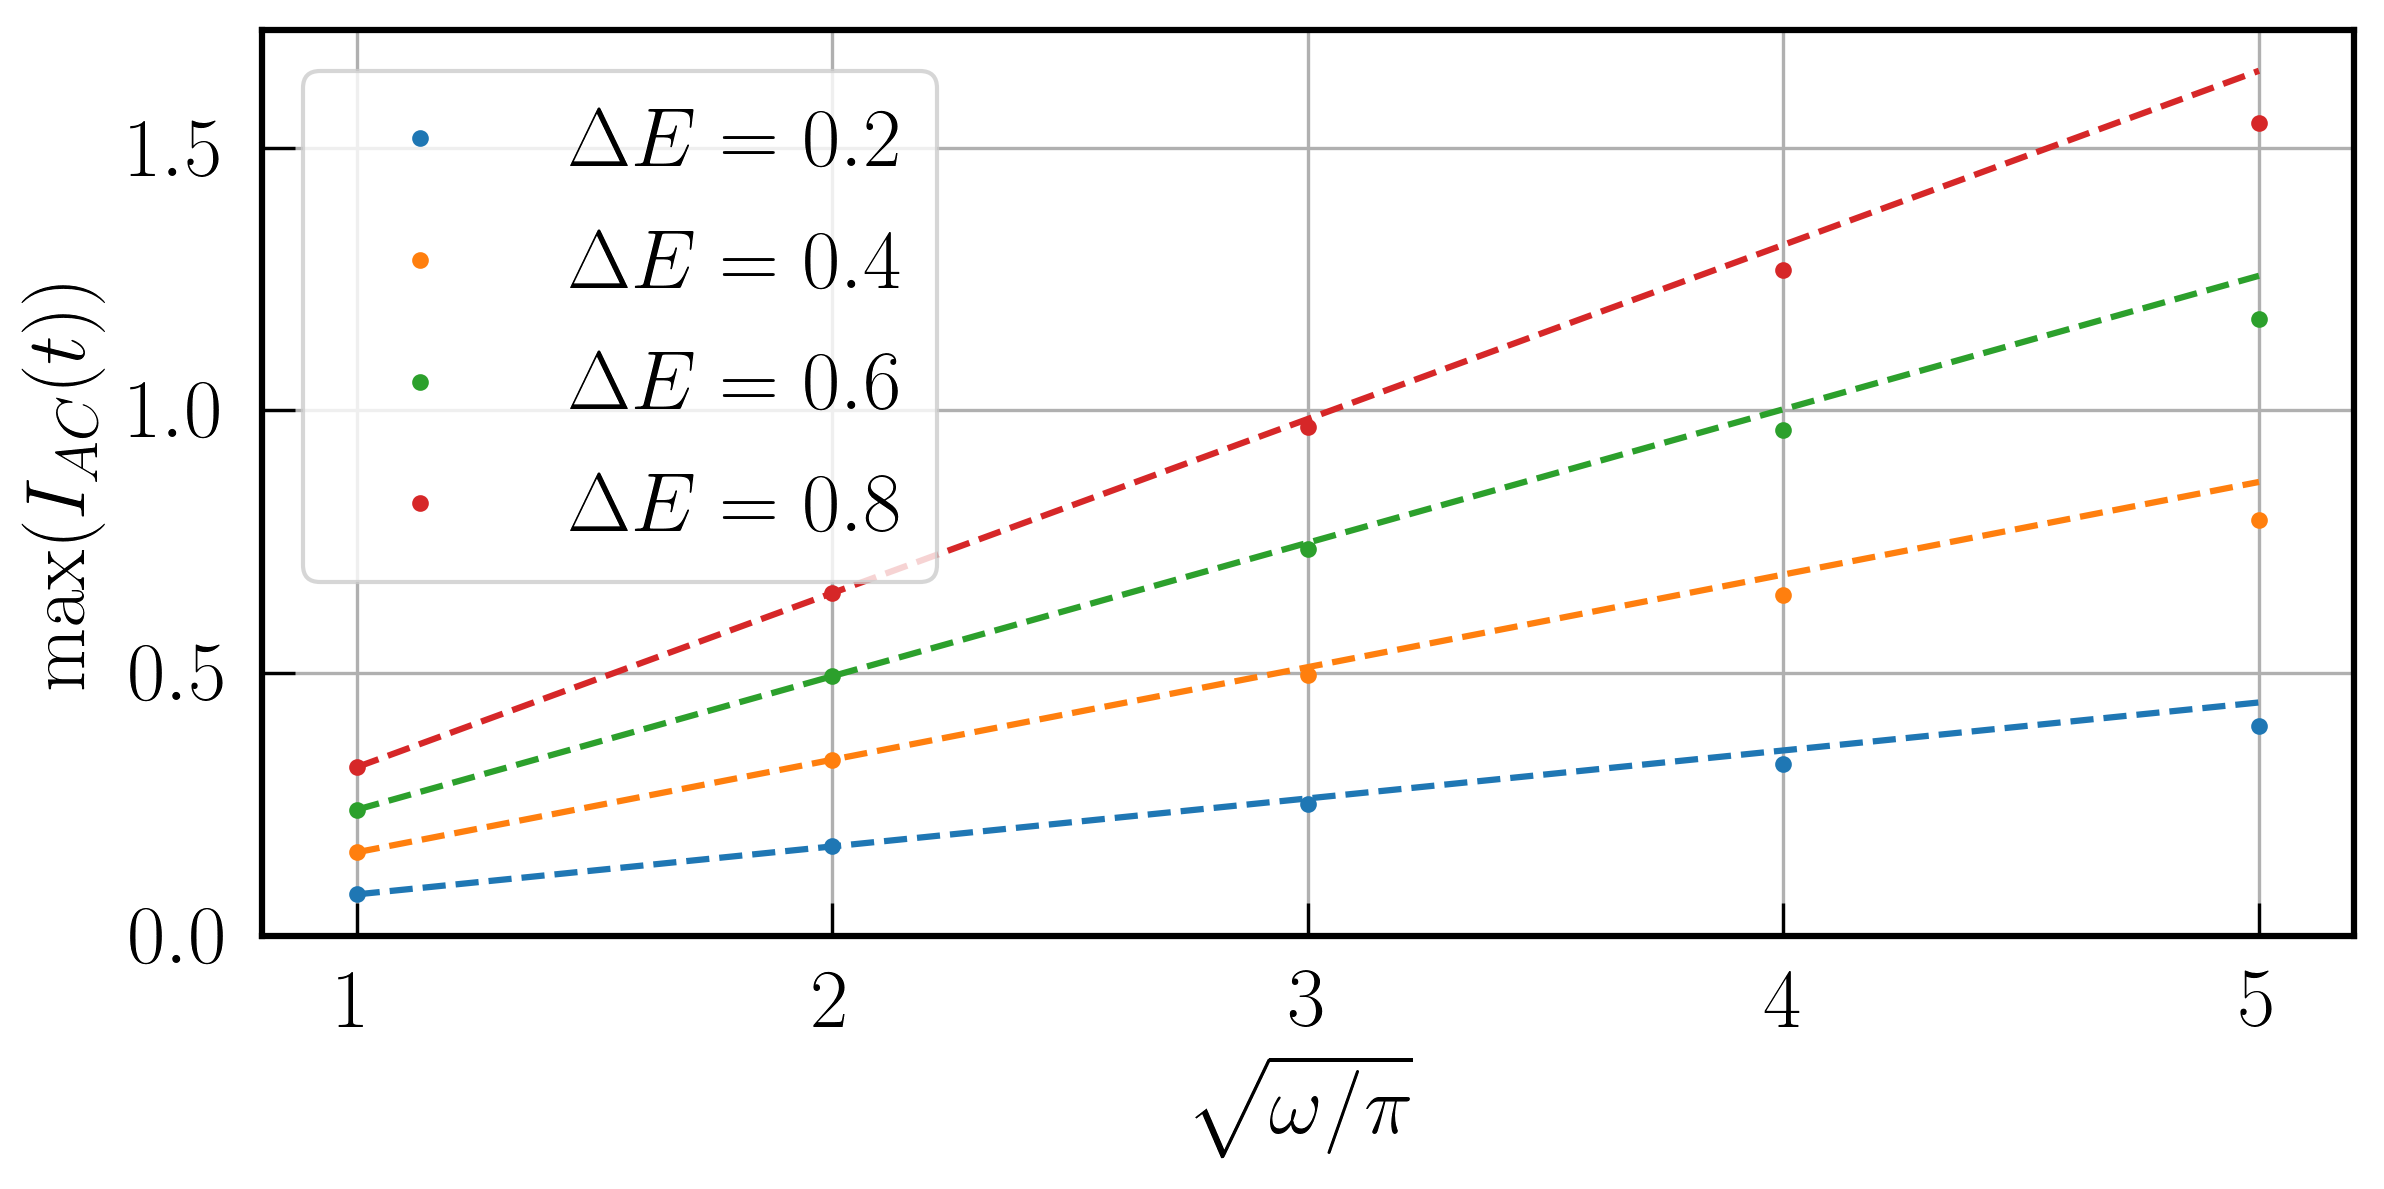

In [52]:
pl.plot(np.sqrt(deltaomega_array / np.pi), peaks1, 'C0.', label = r'$\Delta E = 0.2$')
pl.plot(np.sqrt(deltaomega_array / np.pi), f1(np.sqrt(deltaomega_array / np.pi)), 'C0--')

pl.plot(np.sqrt(deltaomega_array / np.pi), peaks2, 'C1.', label = r'$\Delta E = 0.4$')
pl.plot(np.sqrt(deltaomega_array / np.pi), f2(np.sqrt(deltaomega_array / np.pi)), 'C1--')

pl.plot(np.sqrt(deltaomega_array / np.pi), peaks3, 'C2.', label = r'$\Delta E = 0.6$')
pl.plot(np.sqrt(deltaomega_array / np.pi), f3(np.sqrt(deltaomega_array / np.pi)), 'C2--')

pl.plot(np.sqrt(deltaomega_array / np.pi), peaks4, 'C3.', label = r'$\Delta E = 0.8$')
pl.plot(np.sqrt(deltaomega_array / np.pi), f4(np.sqrt(deltaomega_array / np.pi)), 'C3--')

pl.xlabel(r'$\sqrt{\omega/\pi}$')
pl.ylabel(r'$\max(I_{AC}(t))$')
pl.grid()
pl.legend()
pl.savefig('peak_currents2.png', bbox_inches = 'tight')